# 11.Sequence to Sequence (Seq2Seq)

In [2]:
import torch 
import torch.nn as nn
from torch.utils import data
from torch.nn import functional as F

import os
import re
import math
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from d2l import torch as d2l

## Seq2Seq Learning

Following the **encoder-decoder** architecture, the **encoder** encodes the variable-length sequences input to the **hidden state** of the RNN. Then, the **decoder** predicts the next token based on the **observed output sequence** and the **encoded state**.

The following diagram shows how to use two RNNs for seq2seq learning in machine translation:

![](http://d2l.ai/_images/seq2seq.svg)

The **final hidden states** of the encoder is used to **initialize** the hidden states of the decoder. By such way, the **information encoded** by the encoder is passed to the decoder. Then, the decode starts making predictions based on the **hidden states** provided by the encoder and the initial special token **"\<bos>"**.

## Teacher Force

**Teacher forcing** is an algorithm for training the weights of RNNs. It involves feeding the **observed sequence values** (i.e. ground-truth samples) back into the RNN after each step, thus forcing the RNN to **stay close to the ground-truth sequence**.

Here, the special token **“\<bos>”** and the **original target sequence** (excluding the final token **“\<eos>”**) are concatenated as input to the decoder, while the decoder output (labels for training) is the original target sequence **shifted by one token**.

## Encoder

We use **recurrent neural networks** to design the encoder.

Consider the **input sequence** $x_1, \ldots, x_T$, the **RNN** transforms $\mathbf{x}_t$ and $\mathbf{h} _{t-1}$ into $\mathbf{h}_t$:

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1})$$

The **encoder** converts the **hidden states** at all time steps into a **context variable**:

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T)$$

We can also use a **bidirectional RNN** to design the encoder so that the **hidden state** encodes the information of both the **leftward and rightward** context.

Note that in the following implementation, we included an **embedding layer** to obtain the **feature vector** for each token in the input sequence. The **weight** of the embedding layer has **number of rows** = `vocab_size` and **number of columns** = `embed_size` (each row is a feature vector for a token in the vocabulary).

In [3]:
class Seq2SeqEncoder(d2l.Encoder):

    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        #X shape: (batch_size, num_steps)
        #Embedding layer output shape: (batch_size, num_steps, embed_size)
        X = self.embedding(X)
        #rotate the input tensor: the first dimension for RNN should be num_steps
        X = X.permute(1, 0, 2)
        #outputs shape: (num_steps, batch_size, num_hiddens)
        #state shape: (num_layers, batch_size, num_hiddens)
        output, state = self.rnn(X)
        return output, state

Let's instantiate the encoder with 2 GRUs with 16 hidden units. The input is a mini-batch $X$ with batch size 7 and time steps 4:

In [4]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()

X = torch.zeros((4,7), dtype=torch.long)

output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

## Decoder

The encoder encodes the information of the entire **input sequence** $x_1, \ldots, x_T$ into a **context variable** $\mathbf{c}$. Then, the decoder predicts $y_{t'}$ based on $\mathbf{c}$ and the **observed output sequence** $y_1, \ldots, y_{t'-1}$, that is $P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$.

To model such conditional probability with a **RNN**, we compute the **hidden state** $\mathbf{s}_{t^\prime}$ with $\mathbf{c}$, $y_{t^\prime-1}$ and the **previous hidden state** $\mathbf{s}_{t^\prime-1}$:

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1})$$

With the hidden states of the decoder, we can use an **output layer** and a **softmax function** to compute $P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$.

Note, when implementing the decoder, we **initialize** the hidden states with the hidden states of the encoder at the **final time step**. Therefore, we require the encoder and decoder to have the **same number of layers and hidden units**. 

To pass the encoded information to the decoder, we **concatenate** the **context variable** and the **decoder input** at all time steps. Note that the **context variable** in the following is defined as the **last hidden state** of the encoder.

In [7]:
class Seq2SeqDecoder(d2l.Decoder):

    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        #X shape: (batch_size, num_steps)
        #Embedding layer output shape: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        #context shape: (batch_size, num_hiddens)
        context = state[-1]
        #Broadcast context to: (num_steps, batch_size, num_hiddens)
        context = context.repeat(X.shape[0], 1, 1)
        #Concatenate at the feature dimension
        X_and_context = torch.cat((X, context), 2)
        #outputs shape: (batch_size, num_steps, vocab_size)
        #hidden_state shape: (num_layers, batch_size, num_hiddens)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        return output, state

In [8]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()

state = decoder.init_state(encoder(X))
output, state = decoder(X, state)

output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

To summerize:

1. the encoder takes in the input sequence and uses multiple RNN layers to obtain outputs and hidden states
2. the enocoder hiddens states is use to intialize the RNN layers in the decoder
3. the context variable is extract from the encoder hidden states
4. the context variable is concated with the embedded and shifted target sequence 
5. the decoder then use multiple RNN layers to obtain outputs 
6. the outputs are passed through a dense layer with softmax functions to obtain the predicted probability distribution

![](http://d2l.ai/_images/seq2seq-details.svg)

## Loss Function

Note that we use **padding** to load the mini-batches for training. However, these **padding tokens** should not be considered when computing the **loss**.

Therefore, we first defien a **sequence_mask** function to mask out irrelavent tokens by **centralizing** their mean to zero.

In [56]:
def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :]
    mask = mask < valid_len[:, None]
    X[~mask] = value
    return X

In [57]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [58]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=0)

tensor([[[1., 1., 1., 1.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [0., 0., 0., 0.]]])

Now, we can define our masked softmax loss function by inheriting the **CrossEntropyLoss** class:

In [59]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    
    #pred shape：(batch_size, num_steps, vocab_size)
    #laebl shape：(batch_size, num_steps)
    #valid_len shapre：(batch_size, ) 
    
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [60]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), 
     torch.ones((3, 4), dtype=torch.long), 
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

## Training

In [69]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):

    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    net.train()
    
    loss = MaskedSoftmaxCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])
    
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  
        
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            
            bos = torch.tensor([tgt_vocab['<bos>']]*Y.shape[0], device=device).reshape(-1,1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  #teacher force
            
            Y_hat, _ = net(X, dec_input, X_valid_len)
            
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
                
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
            
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss 0.019, 5961.1 tokens/sec on cpu


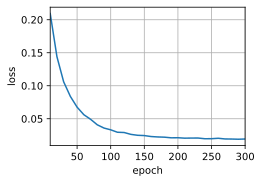

In [70]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)

train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## Prediction

To predict the target sequence **token by token**, the prediction at the **previous time step** becomes the input at the **current time step** (in training, the original target sequence is used as input instead of the predictions).

The model stop predicting new tokens when the last prediction is the **end token (\<eos>)**.

![](http://d2l.ai/_images/seq2seq-predict.svg)

In [64]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):

    net.eval()
    
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)

    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()

        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)

        if pred == tgt_vocab['<eos>']:
            break
            
        output_seq.append(pred)
        
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

## Evaluating the Predicted Sequence

The **BLEU (bilingual evaluation understudy)** is a widely used metric to evaluate the quality of predicted sequences:

$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n}$$

where $\mathrm{len}_{\text{label}}$ is the **number of tokens in the target sequence**, $\mathrm{len}_{\text{pred}}$ is the **number of tokens in the predicted sequence**, $k$ is the **longest $n$-grams** for matching.

Denote by $p_n$ the **precision of n-grams**, which is the **ratio** of the number of **matched n-grams** in the predicted and target sequences to the number of n-grams in the predicted sequence. For example, for a **target sequence** $A$, $B$, $C$, $D$, $E$, $F$ and a **predicted sequence** $A$, $B$, $B$, $C$, $D$, we have $p_1 = 4/5$, $p_2 = 3/4$, $p_3 = 1/3$ and $p_4 = 0$.

According to the definition of **BLEU**, it has **value of 1** when the predicted sequence **perfectly matches** the target sequence.

Since **longer $n$-grams** are harder to predict, they are given **larger weights** (i.e. $p_n^{1/2^n}$ grows with $n$). Moreover, the **coefficent** at the beginnig of the formula is used to **penalize short predicted sequences** which will have higher $p_n$ scores.

In [65]:
def bleu(pred_seq, label_seq, k):  
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [71]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est mouillé ., bleu 0.658
i'm home . => je suis chez moi certain ., bleu 0.803
